<a href="https://colab.research.google.com/github/makingthefuturehappy/NNs/blob/main/RNN_Movie_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Competition description: https://www.kaggle.com/c/sf-dl-movie-genre-classification<br>
<b>Results:</b><br>
Base model: val_loss: 1.1322 - val_accuracy: 0.6630 | Kaggle - 0.65896<br> 



In [2]:
%%capture

!pip install ktrain
import tensorflow as tf
import ktrain
from ktrain import text

import random
import numpy as np 
import pandas as pd 
# plt
import matplotlib.pyplot as plt

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg' #графики в svg выглядят более четкими
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
PATH_GDRIVE = '/content/drive/My Drive/Colab Notebooks/RNN Movie Classification/data/'
DATA_PATH = '/content/data/'

# little heplers
%config IPCompleter.greedy=True  # более лучший автокомплит
!pip install gTTS #text to Speach lib for notifications
from gtts import gTTS
from IPython.display import Audio
def Notification(text = 'task is done'):
  tts = gTTS(text)
  print(text)
  tts.save('notification.wav')
  sound_file = 'notification.wav'
  return Audio(sound_file, autoplay=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/1AfDhmrj9rRXTSF1yNDc0ug3jWYQUZU0d3sdUBALH2g3DlflYBNSP_7TtDSs


In [3]:
!nvidia-smi -L ##GPU count and name

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
## copy files from G-Drive to Colab env.
import zipfile
import shutil

print('unpacking dataset...')
with zipfile.ZipFile(PATH_GDRIVE + 'Archive.zip',"r") as z:
  z.extractall(DATA_PATH)

shutil.rmtree(DATA_PATH + '__MACOSX')
print('data uploaded.')

unpacking dataset...
data uploaded.


In [5]:
EPOCH     = 4
LR        = 1e-5
VAL_SPLIT = 0.10  #15%

MAX_WORDS = 20000 # The maximum number of words to be used. (most frequent)
MAXLEN    = 100 # Max number of words in each complaint.

In [6]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')
train.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


Text(0, 0.5, 'Counts')

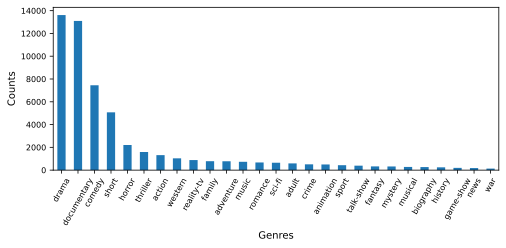

In [7]:
train.genre.value_counts().plot(kind='bar',figsize=(8,3),fontsize=8)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

In [ ]:
#@title Stratified DataSet setup for HParam tuning
min_qnnty_genre = train.genre.value_counts().min()
research_df = train.groupby('genre',
														group_keys=False).apply(lambda x: x.sample(min_qnnty_genre))
              
research_df.genre.value_counts().plot(kind='bar',figsize=(8,3),fontsize=8)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

In [ ]:
train['text'] = train['name'].apply(lambda x: x[:-7])
train.text = train.name + train.text

In [ ]:
# Подготовим таргеты
classes =  list(set(train.genre))
train = train[['text', 'genre']]
train = pd.get_dummies(train, prefix='', prefix_sep='', columns=['genre',])
train.to_csv('train_df.csv', index=False)
train.head(3)

,text,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game-show,history,horror,music,musical,mystery,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Listening in to a conversation between his do...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A brother and sister with a past incestuous r...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,As the bus empties the students for their fie...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train, 
                                                                   text_column='text',
                                                                   label_columns=classes,
                                                                   val_pct=VAL_SPLIT, 
                                                                   max_features=MAX_WORDS, 
                                                                   maxlen=MAXLEN,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )

Is Multi-Label? False
maxlen is 100
done.


In [ ]:
learner = ktrain.get_learner(model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test))

In [ ]:
# learner.lr_find(max_epochs =2)
# Notification()
# learner.lr_plot()

In [ ]:
learner.autofit(1e-5, EPOCH)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/4
1525/1525 [==============================] - 2245s 1s/step - loss: 1.6906 - accuracy: 0.5295 - val_loss: 1.2407 - val_accuracy: 0.6322
Epoch 2/4
1525/1525 [==============================] - 2247s 1s/step - loss: 1.1655 - accuracy: 0.6499 - val_loss: 1.1463 - val_accuracy: 0.6490
Epoch 3/4
1525/1525 [==============================] - 2249s 1s/step - loss: 1.0208 - accuracy: 0.6872 - val_loss: 1.1189 - val_accuracy: 0.6603
Epoch 4/4
1525/1525 [==============================] - 2245s 1s/step - loss: 0.8983 - accuracy: 0.7248 - val_loss: 1.1322 - val_accuracy: 0.6630


In [ ]:
learner.save_model(PATH_GDRIVE + 'basemodel.model')
Notification()

In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

# Submission

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('predictor_basemodel')
predict = predictor.predict(test.text.values)

submission = pd.DataFrame({'id':range(1, len(predict)+1),'genre':predict},columns=['id', 'genre'])
submission.to_csv(PATH_GDRIVE + 'submission.csv', index=False)
submission.head()

,id,genre
0,1,short
1,2,comedy
2,3,documentary
3,4,drama
4,5,action


In [ ]:
Notification()

# test

In [ ]:
%%capture

!pip install ktrain
import ktrain

from ktrain import text
ts = text.TransformerSummarizer()

In [ ]:
#@title long text
sample_doc = """
New York (CNN Businss)Tesla reported record sales for the third quarter, but its high-flying stock still suffered a sell-off on the news.

The electric automaker delivered a total of 139,300 cars in the quarter -- easily clearing the previous record of 112,000 cars it delivered in the last three months of 2019 before the pandemic affected production and deliveries.
Tesla's gain also outperformed other traditional automakers, most of whom reported lower third-quarter sales compared to a year earlier.
Yet, Tesla's (TSLA) shares closed down 7% on Friday.
Analyst Dan Ives of Wedbush Securities described the sell-off as a "knee-jerk" reaction.
"As the street digests this eye-popping number, the stock should head higher over the coming days and weeks," he wrote in a report, noting the sales figure beat Wall Street estimates of 136,350 cars.
A Biden presidency could boost Tesla and the auto industry
A Biden presidency could boost Tesla and the auto industry
CEO Elon Musk had written an email to Tesla employees two weeks ago, telling them the company had a shot at record deliveries and saying it was important that the company reach that goal.
Tesla recently added its first plant in China and started production of a new car, the Model Y, its lowest priced SUV.
"We believe China was a major source of strength this quarter," Ives wrote, adding that the record car sales "should translate into a nice [earnings] upside vs the street for third quarter, with the profitability trajectory on an upward path moving forward."
Despite the drop on Friday, Tesla shares are still up nearly 400% for the year.
The third-quarter sales figure included 15,200 of the more expensive Model S and Model X cars, and 124,100 of the lower-priced Model 3 sedan and Model Y SUV.
"""

In [ ]:
ts.summarize(sample_doc)



"Cassini is a joint NASA/ESA project designed to accomplish an exploration of the Saturnian system with its Cassini Saturn Orbiter and Huygens Titan Probe. The Cassini mission is named for Jean Dominique Cassini (1625-1712) who discovered several of Saturn's satellites and the major division in its rings."



Information on upcoming or currently active missions not mentioned below would be welcome. Cassini is a joint NASA/ESA project designed to accomplish an exploration of the Saturnian system. JPL has developed a backup plan for the first resolved images of an asteroid, Gaspra, while in transit to Jupiter.